""" This note book simulates the variational ansatz and estimates the cost function without
shadow tomography. """

In [1]:
# General imports
import numpy as np
import qiskit
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import DensityMatrix, partial_trace
# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [2]:
# [Reference]: https://docs.quantum.ibm.com/guides/build-noise-models
# https://docs.quantum.ibm.com/guides/simulate-with-qiskit-aer

from qiskit_aer import AerSimulator

from qiskit_aer.primitives import SamplerV2 as Sampler
#from qiskit_ibm_runtime import SamplerV2 as Sampler
# from qiskit.primitives import StatevectorSampler
# sampler = StatevectorSampler()
sampler = Sampler()


from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.noise import (NoiseModel,QuantumError,ReadoutError,depolarizing_error,pauli_error,thermal_relaxation_error)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# YOUR_API_TOKEN = "a44932650c6324c729fbd156e2808cff2dc96cc78fdaf3058a5e3583edfadad4acf73471140788f0efa7ed71a98f1e13069af52fe115e4e0e2bb868ab0be5d70"
# QiskitRuntimeService.save_account(channel="ibm_quantum", token= YOUR_API_TOKEN, overwrite = True)
# service = QiskitRuntimeService()
# backend = service.backend("ibm_brisbane")
# noise_model = NoiseModel.from_backend(backend)

In [3]:
from scipy.sparse import csr_matrix
from scipy.sparse import csr_matrix, kron
from numpy import trace

In [4]:
# VQA circuit.
from qiskit import QuantumCircuit, transpile

I = np.array([[1,0],[0,1]])
sigma_x = np.array([[0,1],[1,0]])
sigma_y = np.array([[0,-1j],[1j,0]])
sigma_z = np.array([[1,0],[0,-1]])

N_qubits = 2 # Number of qubits in the circuit
def vqa_circuit(theta_x, theta_y, theta_z, phi):
     vqa_circuit = QuantumCircuit(N_qubits)
     vqa_circuit.rx(theta_x, 0)
     vqa_circuit.ry(theta_y, 0)
     vqa_circuit.rz(theta_z, 0)
     vqa_circuit.cry(phi, 0, 1)
     return vqa_circuit

def anstaz_circuit(angles_lst, number_of_layers):  

     number_of_angles_per_layer = 4

     if len(angles_lst*number_of_angles_per_layer) % number_of_layers != 0:
         raise ValueError("The number of angles should be divisible by the number of layers.")
     else:
           n_qubits = 1
           anstaz_circuit = QuantumCircuit(n_qubits+1)
           for i in range(number_of_layers):
               anstaz_circuit.rx(angles_lst[i][0], 0)
               anstaz_circuit.ry(angles_lst[i][1], 0)
               anstaz_circuit.rz(angles_lst[i][2], 0)
               anstaz_circuit.cry(angles_lst[i][3],0,1)  
               anstaz_circuit.reset(0)
     return anstaz_circuit     

In [5]:
# # Drawing the circuit for visualization.
# trans_vqa = transpile(anstaz_circuit([(0.1,0.2,0.3,0.4), (0.1,0.2,0.3,0.4)],2), basis_gates = ["rx", "ry", "rz", "cx"])
# trans_vqa.draw("mpl", scale=1.5)

In [6]:
def cost_function(b, gamma_1, gamma_2, rho):

     # Coefficients in the cost function.
     f00 = b**2/2 + 5*gamma_1**2/8 + gamma_1*gamma_2 + 2*gamma_2**2
     f02 = - b*gamma_1
     f03 = -gamma_1**2
     f11 = -b**2/2
     f33 = 3*gamma_1**2/8 - gamma_1*gamma_2 - 2*gamma_2**2
     f23 = b*gamma_1/2 - 2*gamma_2*b

     return np.real(
          f00 * np.trace(rho@rho) + 
          f02 * np.trace(rho@rho@sigma_y) +
          f03 * np.trace(rho@rho@sigma_z) +
          f11 * np.trace(rho@sigma_x@rho@sigma_x) +
          f33 * np.trace(rho@sigma_z@rho@sigma_z) +
          f23 * np.trace(rho@sigma_y@rho@sigma_z)
     )


def return_density_matrix(quantum_circuit):

     quantum_circuit.save_density_matrix()  # Save the density matrix

     # Step 2: Simulate the circuit
     simulator = AerSimulator()  # Aer simulator supports reset gates
     quantum_circuit = transpile(quantum_circuit, simulator)
     result = simulator.run(quantum_circuit).result()
     # Step 3: Extract the density matrix
     rho_full = DensityMatrix(result.data()["density_matrix"])

     # Step 4: Compute the reduced density matrix for the second qubit
     rho_1 = partial_trace(rho_full, [0])  # Trace out qubit 0
     rho_1_matrix = rho_1.data

     return rho_1_matrix

In [20]:
tolerance_for_convergence = 1.e-2
theta_x = np.random.uniform(-np.pi, np.pi)
theta_y = np.random.uniform(-np.pi, np.pi)
theta_z = np.random.uniform(-np.pi, np.pi)
phi = np.random.uniform(-np.pi, np.pi)

theta_x_2 = np.random.uniform(-np.pi, np.pi)
theta_y_2 = np.random.uniform(-np.pi, np.pi)
theta_z_2 = np.random.uniform(-np.pi, np.pi)
phi_2 = np.random.uniform(-np.pi, np.pi)

#print("Initial set of parameters =", theta_x, theta_y, theta_z, phi)

initial_learning_rate = 4
number_of_iterations = 0
max_iterations = 200

best_cost = float("inf")
best_theta_x, best_theta_y, best_theta_z, best_phi = theta_x, theta_y, theta_z, phi
best_iteration = 0

b = 1
gamma_1 = 0.2
gamma_2 = 0.4

cost_function_values = []
theta_x_values = []
theta_y_values = []
theta_z_values = []
phi_values = []

number_of_layers = 2

while number_of_iterations < max_iterations:

     number_of_layers = 1
     #vqa = vqa_circuit(theta_x, theta_y, theta_z, phi)
     vqa = anstaz_circuit([(theta_x_1, theta_y_1, theta_z_1, phi_1),
                          (theta_x_2, theta_y_2, theta_z_2, phi_2)], number_of_layers)

     rho = return_density_matrix(vqa)
     cost_value = cost_function(b, gamma_1, gamma_2, rho)
     cost_function_values.append(cost_value)

     # Update best parameters if a new minimum cost is found
     if cost_value < best_cost:
          best_cost = cost_value
          best_theta_x, best_theta_y, best_theta_z, best_phi = theta_x, theta_y, theta_z, phi
          best_iteration = number_of_iterations  # Update iteration number for best cost    

     if cost_value <= tolerance_for_convergence:
          print("\n[CONVERGED] Cost function is less than the tolerance value.\n")
          print("Cost function =", cost_value)
          print("Optimized parameters =", theta_x, theta_y, theta_z, phi)
          break

     # Decaying learning rate
     learning_rate = initial_learning_rate / np.sqrt(number_of_iterations + 1)

     # Gradient calculation
     vqa_circuit_x_plus = vqa_circuit(theta_x + np.pi/2, theta_y, theta_z, phi)
     vqa_circuit_x_minus = vqa_circuit(theta_x - np.pi/2, theta_y, theta_z, phi)
     vqa_circuit_y_plus = vqa_circuit(theta_x, theta_y + np.pi/2, theta_z, phi)
     vqa_circuit_y_minus = vqa_circuit(theta_x, theta_y - np.pi/2, theta_z, phi)
     vqa_circuit_z_plus = vqa_circuit(theta_x, theta_y, theta_z + np.pi/2, phi)
     vqa_circuit_z_minus = vqa_circuit(theta_x, theta_y, theta_z - np.pi/2, phi)
     vqa_circuit_phi_plus = vqa_circuit(theta_x, theta_y, theta_z, phi + np.pi/2)
     vqa_circuit_phi_minus = vqa_circuit(theta_x, theta_y, theta_z, phi - np.pi/2)

     gradient_theta_x = (cost_function(b, gamma_1, gamma_2, return_density_matrix(vqa_circuit_x_plus)) - cost_function(b, gamma_1, gamma_2, return_density_matrix(vqa_circuit_x_minus)))/2
     gradient_theta_y = (cost_function(b, gamma_1, gamma_2, return_density_matrix(vqa_circuit_y_plus)) - cost_function(b, gamma_1, gamma_2, return_density_matrix(vqa_circuit_y_minus)))/2
     gradient_theta_z = (cost_function(b, gamma_1, gamma_2, return_density_matrix(vqa_circuit_z_plus)) - cost_function(b, gamma_1, gamma_2, return_density_matrix(vqa_circuit_z_minus)))/2
     gradient_phi = (cost_function(b, gamma_1, gamma_2, return_density_matrix(vqa_circuit_phi_plus)) - cost_function(b, gamma_1, gamma_2, return_density_matrix(vqa_circuit_phi_minus)))/2


     # Parameter update
     theta_x -= learning_rate * gradient_theta_x
     theta_y -= learning_rate * gradient_theta_y
     theta_z -= learning_rate * gradient_theta_z
     phi -= learning_rate * gradient_phi

     theta_x_values.append(theta_x)
     theta_y_values.append(theta_y)
     theta_z_values.append(theta_z)
     phi_values.append(phi)

     number_of_iterations += 1
     print("Cost function =", cost_value)
     print("Number of iterations =", number_of_iterations)
     print("Learning rate =", learning_rate)

     if number_of_iterations == max_iterations:
          print("\n[STOPPED] Maximum number of iterations reached.\n")
          print("Cost function =", cost_value)
          print("Optimized parameters =", theta_x, theta_y, theta_z, phi)
          print("\n[RESULT] Minimum cost encountered =", best_cost)
          print("Parameters corresponding to minimum cost =", best_theta_x, best_theta_y, best_theta_z, best_phi)
          print("Iteration number for minimum cost =", best_iteration)
          break

Cost function = 0.12544351338640092
Number of iterations = 1
Learning rate = 4.0
Cost function = 0.14541740384261484
Number of iterations = 2
Learning rate = 2.82842712474619
Cost function = 0.14130275607895484
Number of iterations = 3
Learning rate = 2.3094010767585034
Cost function = 0.13029295269117483
Number of iterations = 4
Learning rate = 2.0
Cost function = 0.13471032552012097
Number of iterations = 5
Learning rate = 1.7888543819998317
Cost function = 0.14681548466856162
Number of iterations = 6
Learning rate = 1.6329931618554523
Cost function = 0.14472333809927787
Number of iterations = 7
Learning rate = 1.5118578920369088
Cost function = 0.15036872454585118
Number of iterations = 8
Learning rate = 1.414213562373095
Cost function = 0.14130275607895484
Number of iterations = 9
Learning rate = 1.3333333333333333
Cost function = 0.1433451559518761
Number of iterations = 10
Learning rate = 1.2649110640673518
Cost function = 0.1717990661066367
Number of iterations = 11
Learning rat

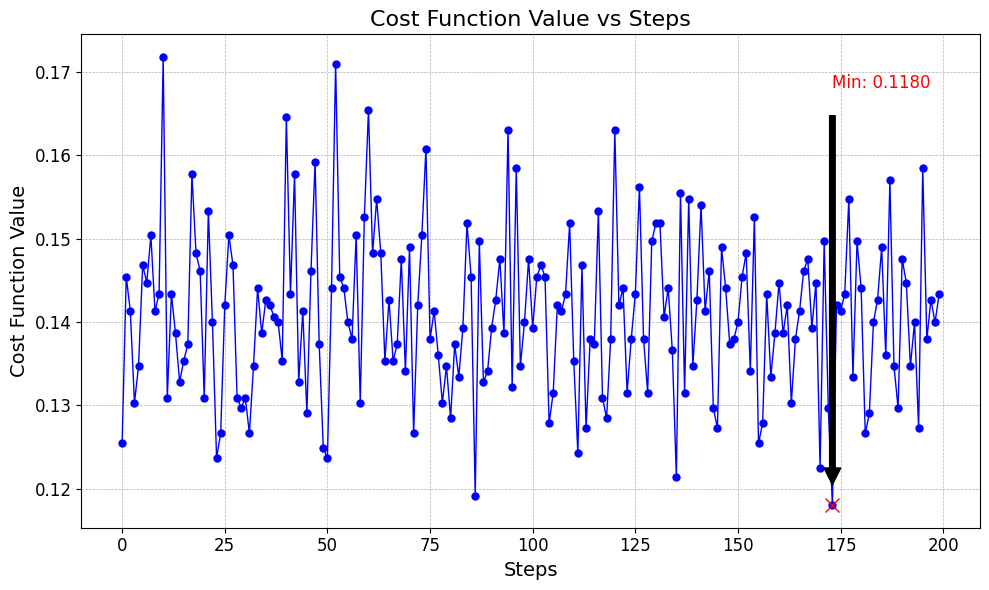

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(cost_function_values, marker="o", linestyle='-', color='b', markersize=5, linewidth=1)
plt.xlabel('Steps', fontsize=14)
plt.ylabel('Cost Function Value', fontsize=14)
plt.title('Cost Function Value vs Steps', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Mark the minimum cost function value
min_cost_value = min(cost_function_values)
min_cost_index = cost_function_values.index(min_cost_value)
plt.plot(min_cost_index, min_cost_value, marker='x', color='r', markersize=10)
plt.annotate(f'Min: {min_cost_value:.4f}', xy=(min_cost_index, min_cost_value), xytext=(min_cost_index, min_cost_value + 0.05),
                arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, color='r')
plt.tight_layout()
plt.show()

# Plot of cost landscape

In [18]:
theta_x_values = np.linspace(-np.pi, np.pi, 50)
theta_y_values = np.linspace(-np.pi, np.pi, 50)
theta_z_values = [0.0] #np.linspace(-np.pi, np.pi, 100)
phi_values = [0.5] #np.linspace(-np.pi, np.pi, 20)

# Here we plot the cost function values for different values of theta_x, theta_y, theta_z, and phi.

cost_function_values_lst = []
for theta_x in theta_x_values:
     for theta_y in theta_y_values:
          for theta_z in theta_z_values:
               for phi in phi_values:
                    cost_value = cost_function(b, gamma_1, gamma_2, return_density_matrix(vqa_circuit(theta_x, theta_y, theta_z, phi)))
                    cost_function_values_lst.append(cost_value)

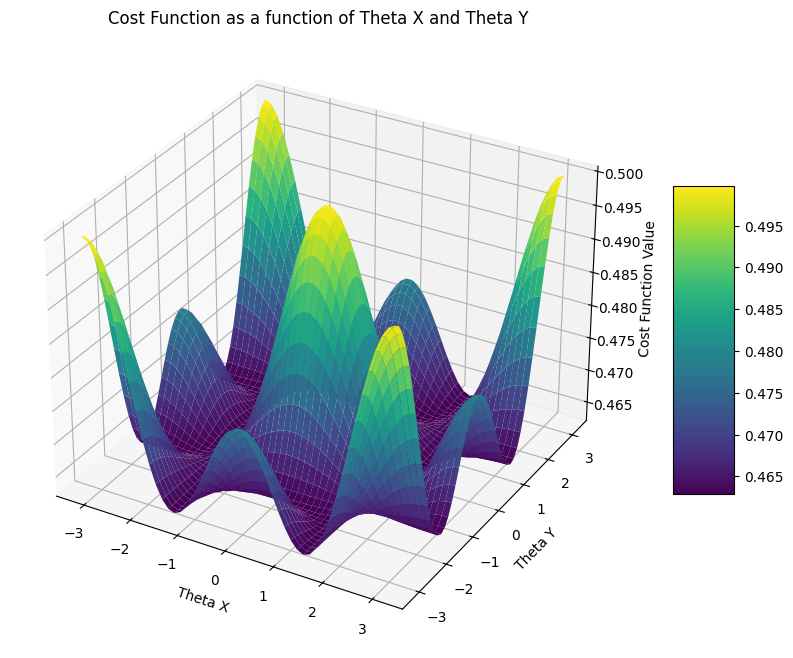

In [19]:
from mpl_toolkits.mplot3d import Axes3D

# Reshape the cost function values to match the grid of theta_x and theta_y
cost_function_values_array = np.array(cost_function_values_lst).reshape(len(theta_x_values), len(theta_y_values))

# Create a meshgrid for theta_x and theta_y
theta_x_mesh, theta_y_mesh = np.meshgrid(theta_x_values, theta_y_values)

# Plotting
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(theta_x_mesh, theta_y_mesh, cost_function_values_array.T, cmap='viridis')

# Add a color bar which maps values to colors
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Labels and title
ax.set_xlabel('Theta X')
ax.set_ylabel('Theta Y')
ax.set_zlabel('Cost Function Value')
ax.set_title('Cost Function as a function of Theta X and Theta Y')

plt.show()